# Bitcoin-JPY（日足）

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = 'BTC-JPY'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-08-21 00:00:00+00:00,8728701.0,9040906.0,8536866.0,8575959.0,4594177021876,0.0,0.0
2024-08-22 00:00:00+00:00,8576278.0,8971374.0,8551380.0,8878123.0,4750148012089,0.0,0.0
2024-08-23 00:00:00+00:00,8877125.0,8969452.0,8698239.0,8828711.0,4039282939013,0.0,0.0
2024-08-24 00:00:00+00:00,8828571.0,9376083.0,8827269.0,9252982.0,6139916965455,0.0,0.0
2024-08-25 00:00:00+00:00,9254355.0,9313529.0,9184489.0,9265200.0,3093826427086,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-17 00:00:00+00:00,14865900.0,14888006.0,14634218.0,14619599.0,2513757699977,0.0,0.0
2025-02-18 00:00:00+00:00,14620203.0,14696454.0,14418603.0,14504017.0,4139874572985,0.0,0.0
2025-02-19 00:00:00+00:00,14504083.0,14672523.0,14192394.0,14514893.0,5670728747144,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

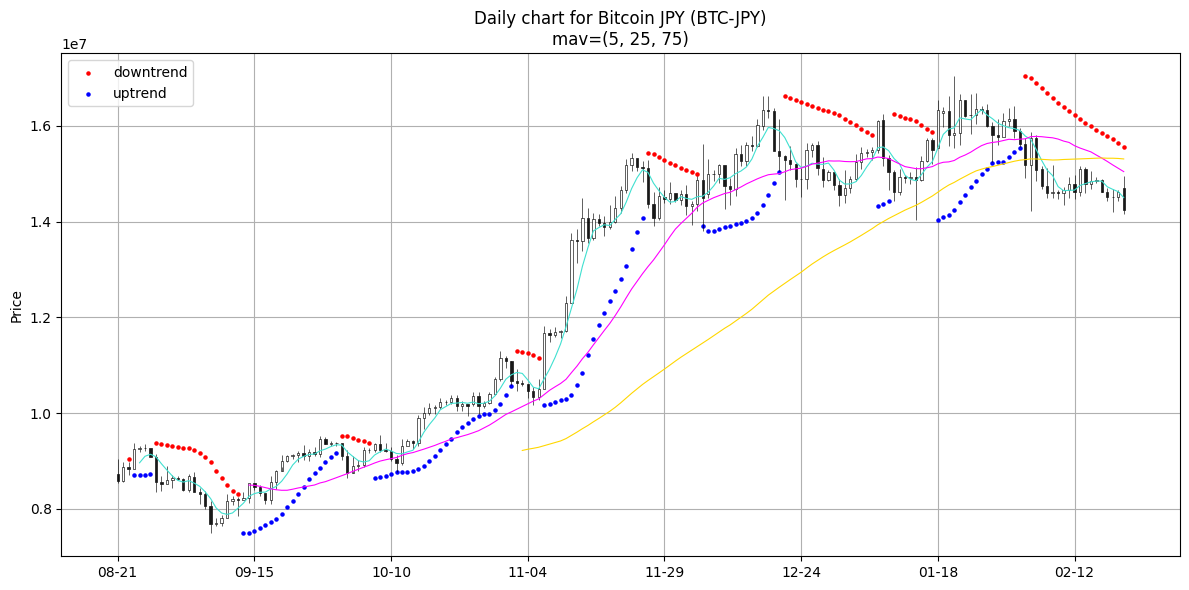

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_excange.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-12-17 00:00:00+00:00    16338671.0
2024-12-18 00:00:00+00:00    16350968.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-12-17 00:00:00+00:00        NaN
2024-12-18 00:00:00+00:00    12297.0
Name: Close, dtype: float64